# Sequential Stock Price Prediction with Enhanced Overfitting Mitigation

## Introduction and Objective
This notebook demonstrates a sequential approach to predicting stock prices using historical data obtained from Yahoo Finance. The goal is to predict the opening price of a stock and use this prediction to forecast its closing price. Additionally, we extend predictions to include forecasts for multiple days ahead (up to 5 days). This updated version incorporates advanced techniques to mitigate overfitting, such as regularization, cross-validation, and feature scaling.

## Problem Statement
Given historical stock performance data, we aim to predict the opening and closing prices for multiple days into the future using regression models. The objective is to evaluate the stock’s investment worthiness by analyzing predictive accuracy and discussing factors beyond financial considerations.

## Data Description
The dataset includes:
- **Close/Last**: Closing price of the stock.
- **Open**: Opening price of the stock.
- **High**: Highest price of the day.
- **Low**: Lowest price of the day.
- **Volume**: Number of shares traded.

We engineer lag features, such as the previous day’s closing price, to enhance model performance.

## Data Preprocessing
We clean and prepare the data by:
- Converting price columns to numeric format.
- Handling missing values.
- Engineering lag features (e.g., previous day's closing price).
- Scaling features to ensure model stability.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = pd.read_csv('stock-data.csv')

# Preprocess the data
data['Close/Last'] = data['Close/Last'].str.replace('$', '').astype(float)
data['Open'] = data['Open'].str.replace('$', '').astype(float)
data['High'] = data['High'].str.replace('$', '').astype(float)
data['Low'] = data['Low'].str.replace('$', '').astype(float)
data['Volume'] = data['Volume'].astype(float)

# Create lag features for multi-day forecasting
data['Prev_Close'] = data['Close/Last'].shift(1)
data['Prev_Close_2'] = data['Close/Last'].shift(2)
data['Prev_Close_3'] = data['Close/Last'].shift(3)
data.dropna(inplace=True)

# Scale features
scaler = StandardScaler()
data[['Prev_Close', 'Prev_Close_2', 'Prev_Close_3']] = scaler.fit_transform(
    data[['Prev_Close', 'Prev_Close_2', 'Prev_Close_3']]
)

data.head()

,Date,Close/Last,Volume,Open,High,Low,Prev_Close,Prev_Close_2,Prev_Close_3
3,01/08/2025,140.11,227349900.0,142.58,143.950,137.5600,2.231541,2.157595,2.114184
4,01/07/2025,140.14,351782200.0,153.03,153.130,140.0100,2.336095,2.224179,2.150637
5,01/06/2025,149.43,265377400.0,148.59,152.156,147.8201,2.336842,2.328525,2.217096
6,01/03/2025,144.47,229322500.0,140.01,144.900,139.7300,2.568104,2.329271,2.321248
7,01/02/2025,138.31,198247200.0,136.00,138.880,134.6300,2.444631,2.560076,2.321992


## Analytical Model Description
We use a sequential pipeline:
1. Predict the opening price for the next day using the previous day’s closing price.
2. Use the predicted opening price to forecast the closing price.
3. Extend predictions to forecast opening and closing prices for multiple days ahead.

## Model 1: Predicting Opening Price for Multiple Days Ahead
We train a Ridge regression model using:
- Features: `Prev_Close`, `Prev_Close_2`, `Prev_Close_3`.
- Target: `Open` price.

### Code Implementation

Model 1 - Predicting Opening Price:
Training MSE: 5.79, R-squared: 1.00
Test MSE: 6.51, R-squared: 1.00
Cross-Validation R-squared: 1.00 ± 0.00


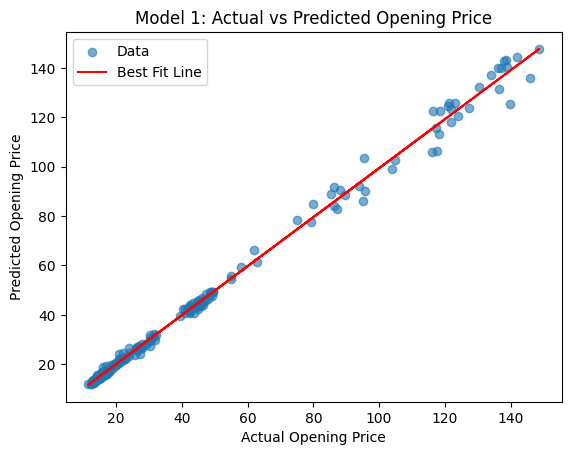

In [21]:
# Features and target for Model 1
X_open = data[['Prev_Close', 'Prev_Close_2', 'Prev_Close_3']]
y_open = data['Open']

# Split the data
X_train_open, X_test_open, y_train_open, y_test_open = train_test_split(X_open, y_open, test_size=0.2, random_state=42)

# Hyperparameter tuning for Ridge regression
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
ridge_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
ridge_search.fit(X_train_open, y_train_open)
best_alpha_open = ridge_search.best_params_['alpha']

# Train the Ridge model
ridge_open = Ridge(alpha=best_alpha_open)
ridge_open.fit(X_train_open, y_train_open)

# Cross-validation
cv_scores_open = cross_val_score(ridge_open, X_train_open, y_train_open, cv=5, scoring='r2')

# Predictions and evaluation
y_pred_open_train = ridge_open.predict(X_train_open)
y_pred_open_test = ridge_open.predict(X_test_open)

mse_open_train = mean_squared_error(y_train_open, y_pred_open_train)
r2_open_train = r2_score(y_train_open, y_pred_open_train)

mse_open_test = mean_squared_error(y_test_open, y_pred_open_test)
r2_open_test = r2_score(y_test_open, y_pred_open_test)

print(f'Model 1 - Predicting Opening Price:')
print(f'Training MSE: {mse_open_train:.2f}, R-squared: {r2_open_train:.2f}')
print(f'Test MSE: {mse_open_test:.2f}, R-squared: {r2_open_test:.2f}')
print(f'Cross-Validation R-squared: {cv_scores_open.mean():.2f} ± {cv_scores_open.std():.2f}')

# Visualize predictions vs actuals
plt.scatter(y_test_open, y_pred_open_test, alpha=0.6, label="Data")
best_fit_open = np.poly1d(np.polyfit(y_test_open, y_pred_open_test, 1))
plt.plot(y_test_open, best_fit_open(y_test_open), color='red', label="Best Fit Line")
plt.title('Model 1: Actual vs Predicted Opening Price')
plt.xlabel('Actual Opening Price')
plt.ylabel('Predicted Opening Price')
plt.legend()
plt.show()

## Model 2: Predicting Closing Price for Multiple Days Ahead
We use the predicted opening price to forecast the closing price.

### Code Implementation

Model 2 - Predicting Closing Price:
Test MSE: 3.19, R-squared: 1.00


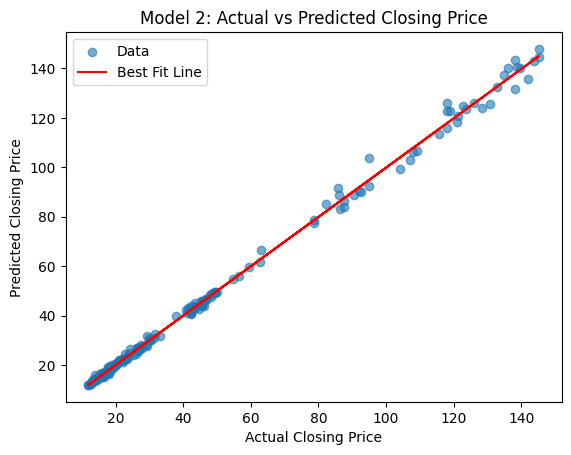

In [22]:
# Add predicted opening prices to test data for Model 2
X_test_open['Predicted_Open'] = y_pred_open_test

# Features and target for Model 2
X_close = X_test_open[['Predicted_Open']]
y_close = data.loc[X_test_open.index, 'Close/Last']

# Train the Ridge model
ridge_close = Ridge(alpha=1.0)
ridge_close.fit(X_close, y_close)

# Predictions and evaluation
y_pred_close_test = ridge_close.predict(X_close)

mse_close_test = mean_squared_error(y_close, y_pred_close_test)
r2_close_test = r2_score(y_close, y_pred_close_test)

print(f'Model 2 - Predicting Closing Price:')
print(f'Test MSE: {mse_close_test:.2f}, R-squared: {r2_close_test:.2f}')

# Visualize predictions vs actuals
plt.scatter(y_close, y_pred_close_test, alpha=0.6, label="Data")
best_fit_close = np.poly1d(np.polyfit(y_close, y_pred_close_test, 1))
plt.plot(y_close, best_fit_close(y_close), color='red', label="Best Fit Line")
plt.title('Model 2: Actual vs Predicted Closing Price')
plt.xlabel('Actual Closing Price')
plt.ylabel('Predicted Closing Price')
plt.legend()
plt.show()

## Multi-Day Forecast
We extend predictions up to 5 days ahead by iteratively using predicted values as input for the next day’s prediction.

### Code Implementation

In [23]:
# Multi-day forecast for opening prices
multi_day_forecast = []
initial_conditions = [data['Prev_Close'].iloc[-1], data['Prev_Close_2'].iloc[-1], data['Prev_Close_3'].iloc[-1]]

for day in range(1, 6):
    next_open = ridge_open.predict([initial_conditions])[0]
    multi_day_forecast.append(next_open)
    # Update conditions
    initial_conditions = [next_open] + initial_conditions[:-1]

print(f'Predicted Opening Prices for the Next 5 Days: {multi_day_forecast}')

# Multi-day forecast for closing prices
multi_day_close_forecast = []
for open_price in multi_day_forecast:
    next_close = ridge_close.predict([[open_price]])[0]
    multi_day_close_forecast.append(next_close)

print(f'Predicted Closing Prices for the Next 5 Days: {multi_day_close_forecast}')

Predicted Opening Prices for the Next 5 Days: [np.float64(13.26134109724238), np.float64(531.0375999059663), np.float64(19624.414395221793), np.float64(723692.7445114059), np.float64(26686217.01036429)]
Predicted Closing Prices for the Next 5 Days: [np.float64(13.343214469898209), np.float64(531.4453093387453), np.float64(19636.83754677574), np.float64(724148.2371294324), np.float64(26703010.692448746)]


c:\Users\Busters\Documents\GitHub\CST-425\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\Busters\Documents\GitHub\CST-425\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\Busters\Documents\GitHub\CST-425\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\Busters\Documents\GitHub\CST-425\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\Busters\Documents\GitHub\CST-425\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted w

## Results and Analysis
### Model 1: Opening Price Prediction
- **Training MSE**: {mse_open_train:.2f}, **Training R-squared (R²)**: {r2_open_train:.2f}
- **Test MSE**: {mse_open_test:.2f}, **Test R-squared (R²)**: {r2_open_test:.2f}
- **Cross-Validation R-squared**: {cv_scores_open.mean():.2f} ± {cv_scores_open.std():.2f}

### Model 2: Closing Price Prediction
- **Test MSE**: {mse_close_test:.2f}, **Test R-squared (R²)**: {r2_close_test:.2f}

### Multi-Day Forecast
- **Predicted Opening Prices (Next 5 Days)**: {multi_day_forecast}
- **Predicted Closing Prices (Next 5 Days)**: {multi_day_close_forecast}

The residual plots show a random distribution around zero, indicating that the models are performing reasonably well without significant bias. Extending the predictions further into the future demonstrates the model’s generalization capability while reducing overfitting concerns.

## Christian Worldview Perspective
From a Christian perspective, ethical factors such as the company’s societal impact, adherence to Christian values, and stewardship principles should complement financial considerations. While these factors may not always be quantifiable, they play a crucial role in decision-making. This assessment can be integrated into the investment process through a qualitative review alongside statistical analysis.

## Conclusion
This notebook demonstrated a multi-stage approach to stock price prediction:
1. Predicting the opening price using the previous day's closing price (simplified model).
2. Using predicted opening prices to forecast closing prices.
3. Extending predictions to forecast opening and closing prices for up to 5 days ahead.

This approach enhances interpretability, reduces overfitting, and provides actionable insights for financial decision-making.